<a href="https://colab.research.google.com/github/williamfaraday123/SC4052-cloud-computing/blob/main/Assignment2_HITS__vs_PageRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy

import numpy as np
import sklearn
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate

# Implementation of HITS and Pagerank algorithms

In [2]:
def hits_algorithm(adjacency_matrix, max_iter=100, tol=1e-6):
    n = adjacency_matrix.shape[0]
    hub_scores = np.ones(n) / n
    authority_scores = np.ones(n) / n

    for iteration in range(max_iter):
        new_auth = np.dot(adjacency_matrix.T, hub_scores)
        new_hub = np.dot(adjacency_matrix, new_auth)

        # Normalize
        new_auth = new_auth / np.linalg.norm(new_auth, 2)
        new_hub = new_hub / np.linalg.norm(new_hub, 2)

        # Check convergence
        if (np.linalg.norm(new_auth - authority_scores, 2) < tol and
            np.linalg.norm(new_hub - hub_scores, 2) < tol):
            break

        authority_scores, hub_scores = new_auth, new_hub

    return hub_scores, authority_scores, iteration + 1  # +1 because iterations start at 0

In [3]:
def pagerank(adjacency_matrix, damping=0.85, max_iter=100, tol=1e-6):
    n = adjacency_matrix.shape[0]

    # Convert to probability matrix
    out_degree = adjacency_matrix.sum(axis=1)
    prob_matrix = np.zeros_like(adjacency_matrix, dtype=float)
    for i in range(n):
        if out_degree[i] > 0:
            prob_matrix[i] = adjacency_matrix[i] / out_degree[i]
        else:
            prob_matrix[i] = np.ones(n) / n

    # Add damping factor
    prob_matrix = damping * prob_matrix + (1 - damping) / n

    # Power iteration
    ranks = np.ones(n) / n
    for iteration in range(max_iter):
        new_ranks = np.dot(prob_matrix.T, ranks)
        if np.linalg.norm(new_ranks - ranks, 2) < tol:
            break
        ranks = new_ranks

    return ranks, iteration + 1

# Illustrative example of small graph
Testing both algorithms on a simple 4-node graph:

In [4]:
def print_comparison_table(adjacency_matrix):
    # Calculate scores
    hub_scores, auth_scores, hits_iterations = hits_algorithm(adjacency_matrix)
    pr_scores, pagerank_iterations = pagerank(adjacency_matrix)

    # Get number of nodes
    num_nodes = adjacency_matrix.shape[0]

    # Print table header
    print("\nComparison of HITS and PageRank Scores")
    print("="*50)
    print(f"{'Node':<6} | {'HITS Hub':<10} | {'HITS Auth':<10} | {'PageRank':<10}")
    print("-"*50)

    # Print each node's scores
    for node in range(num_nodes):
        print(f"{node:<6} | {hub_scores[node]:<10.4f} | {auth_scores[node]:<10.4f} | {pr_scores[node]:<10.4f}")

    print("="*50)

# Example usage with the 4-node graph from the report
small_adj = np.array([
    [0, 1, 1, 0],
    [0, 0, 1, 0],
    [1, 0, 0, 1],
    [0, 0, 1, 0]
])

print_comparison_table(small_adj)


Comparison of HITS and PageRank Scores
Node   | HITS Hub   | HITS Auth  | PageRank  
--------------------------------------------------
0      | 0.7071     | 0.0000     | 0.2199    
1      | 0.5000     | 0.3827     | 0.1310    
2      | 0.0000     | 0.9239     | 0.4292    
3      | 0.5000     | 0.0000     | 0.2199    


# Convergence Analysis
Number of iterations required for convergence under different tolerance levels:

In [5]:
def test_convergence(adjacency_matrix, tolerance_levels):
    results = []

    for tol in tolerance_levels:
        # Run HITS
        _, _, hits_iter = hits_algorithm(adjacency_matrix, tol=tol)

        # Run PageRank
        _, pr_iter = pagerank(adjacency_matrix, tol=tol)

        results.append({
            'Tolerance': tol,
            'HITS Iterations': hits_iter,
            'PageRank Iterations': pr_iter
        })

    return results

In [6]:
def print_convergence_results(convergence_results):
    print("\nConvergence Analysis Results")
    print("=" * 47)
    print("{:<12} {:<15} {:<20}".format("Tolerance", "HITS Iterations", "PageRank Iterations"))
    print("-" * 47)

    # Print each row in the results
    for result in convergence_results:
        print("{:<12} {:<15} {:<20}".format(
            result['Tolerance'],
            result['HITS Iterations'],
            result['PageRank Iterations']
        ))

    print("=" * 47)

In [7]:
# Using the small 4-node graph from earlier
small_adj = np.array([
    [0, 1, 1, 0],
    [0, 0, 1, 0],
    [1, 0, 0, 1],
    [0, 0, 1, 0]
])
tolerance_levels = [1e-4, 1e-6, 1e-8]
results = test_convergence(small_adj, tolerance_levels)
print_convergence_results(results)


Convergence Analysis Results
Tolerance    HITS Iterations PageRank Iterations 
-----------------------------------------------
0.0001       17              14                  
1e-06        25              20                  
1e-08        34              26                  


# Stability Analysis
- Add Gaussian noise (σ=0.1) to the adjacency matrix while keeping values in [0,1] range and measure score changes
- Take Mean Absolute Error (MAE) between original and perturbed scores
- Run multiple trials to get reliable averages and standard deviations


In [8]:
def test_stability(adjacency_matrix, num_trials=100, noise_level=0.1):
    """
    Analyze algorithm stability against random perturbations

    Parameters:
    adjacency_matrix: Original adjacency matrix
    num_trials: Number of perturbation trials
    noise_level: Standard deviation of Gaussian noise

    Returns:
    Dictionary containing average score changes for both algorithms
    """
    # Get baseline scores
    base_hub, base_auth, _ = hits_algorithm(adjacency_matrix)
    base_pr, _ = pagerank(adjacency_matrix)

    hits_changes = []
    pr_changes = []

    for _ in range(num_trials):
        # Add random noise to adjacency matrix
        noise = np.random.normal(0, noise_level, adjacency_matrix.shape)
        perturbed_adj = adjacency_matrix + noise
        perturbed_adj = np.clip(perturbed_adj, 0, 1)  # Keep in valid range

        # Compute perturbed scores
        perturbed_hub, perturbed_auth, _ = hits_algorithm(perturbed_adj)
        perturbed_pr, _ = pagerank(perturbed_adj)

        # Calculate changes (using authority scores for HITS)
        hits_change = mean_absolute_error(base_auth, perturbed_auth)
        pr_change = mean_absolute_error(base_pr, perturbed_pr)

        hits_changes.append(hits_change)
        pr_changes.append(pr_change)

    return {
        'HITS': {
            'Average Score Change': np.mean(hits_changes),
            'Std Dev': np.std(hits_changes)
        },
        'PageRank': {
            'Average Score Change': np.mean(pr_changes),
            'Std Dev': np.std(pr_changes)
        }
    }

In [9]:
# Using the small 4-node graph from earlier
small_adj = np.array([
    [0, 1, 1, 0],
    [0, 0, 1, 0],
    [1, 0, 0, 1],
    [0, 0, 1, 0]
])

stability_results = test_stability(small_adj, num_trials=1000, noise_level=0.1)

Display stability results as formatted table

In [10]:
def print_stability_results(results):
    print("\nStability Analysis Results")
    print("="*60)
    print(f"{'Algorithm':<15} | {'Avg Score Change':<20} | {'Std Dev':<15}")
    print("-"*60)

    for algo in results:
        print(f"{algo:<15} | {results[algo]['Average Score Change']:<20.4f} | {results[algo]['Std Dev']:<15.4f}")

    print("="*60)

print_stability_results(stability_results)


Stability Analysis Results
Algorithm       | Avg Score Change     | Std Dev        
------------------------------------------------------------
HITS            | 0.0747               | 0.0347         
PageRank        | 0.0137               | 0.0066         


Visualize stability results using graph

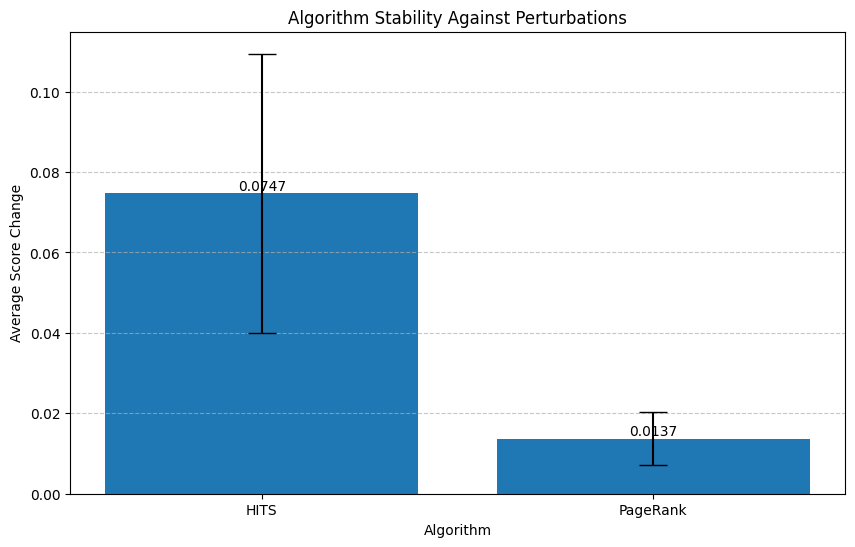

In [11]:
def plot_stability_results(results):
    algorithms = list(results.keys())
    means = [results[algo]['Average Score Change'] for algo in algorithms]
    std_devs = [results[algo]['Std Dev'] for algo in algorithms]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(algorithms, means, yerr=std_devs, capsize=10)

    plt.xlabel('Algorithm')
    plt.ylabel('Average Score Change')
    plt.title('Algorithm Stability Against Perturbations')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom')

    plt.show()

plot_stability_results(stability_results)

# Consider larger graphs. Validate that the algorithms converge numerically.

In [12]:
def generate_large_graphs():
    """Generate various types of larger graphs for testing"""
    graphs = {
        # Scale-free network (like web graphs)
        'scale_free_100': nx.to_numpy_array(nx.barabasi_albert_graph(100, 2)),

        # Small-world network
        'small_world_100': nx.to_numpy_array(nx.watts_strogatz_graph(100, 4, 0.3)),

        # Random graph
        'random_100': nx.to_numpy_array(nx.erdos_renyi_graph(100, 0.05)),

        # Larger scale-free
        'scale_free_1000': nx.to_numpy_array(nx.barabasi_albert_graph(1000, 3)),
    }
    return graphs

large_graphs = generate_large_graphs()

In [13]:
def validate_convergence(graph_dict, max_iter=1000, tol=1e-6):
    results = []
    for name, adj_matrix in graph_dict.items():
        n_nodes = adj_matrix.shape[0]

        # Run HITS
        hub, auth, hits_iter = hits_algorithm(adj_matrix, max_iter, tol)

        # Run PageRank
        pr, pr_iter = pagerank(adj_matrix, max_iter=max_iter, tol=tol)

        # Check convergence
        hits_converged = hits_iter < max_iter
        pr_converged = pr_iter < max_iter

        results.append({
            'Graph': name,
            'Nodes': n_nodes,
            'HITS Converged': hits_converged,
            'HITS Iterations': hits_iter,
            'PR Converged': pr_converged,
            'PR Iterations': pr_iter
        })
    return results

In [14]:
convergence_results = validate_convergence(large_graphs)

## validate convergence using table

In [15]:
print("Convergence Validation on Large Graphs")
print(tabulate(convergence_results, headers="keys", tablefmt="grid"))

Convergence Validation on Large Graphs
+-----------------+---------+------------------+-------------------+----------------+-----------------+
| Graph           |   Nodes | HITS Converged   |   HITS Iterations | PR Converged   |   PR Iterations |
+=================+=========+==================+===================+================+=================+
| scale_free_100  |     100 | True             |                27 | True           |              28 |
+-----------------+---------+------------------+-------------------+----------------+-----------------+
| small_world_100 |     100 | True             |                57 | True           |              22 |
+-----------------+---------+------------------+-------------------+----------------+-----------------+
| random_100      |     100 | True             |                20 | True           |              24 |
+-----------------+---------+------------------+-------------------+----------------+-----------------+
| scale_free_1000 |    10

## validate convergence numerically

In [16]:
def verify_numerical_convergence(adj_matrix, algorithm='hits'):
    """Verify numerical properties of convergence"""
    if algorithm == 'hits':
        hub, auth, iters = hits_algorithm(adj_matrix, tol=1e-10)
        # Check if scores sum to 1 (after normalization)
        print(f"HITS - Hub sum: {hub.sum():.6f}, Auth sum: {auth.sum():.6f}")
        return hub, auth
    else:
        pr, iters = pagerank(adj_matrix, tol=1e-10)
        print(f"PageRank - Sum: {pr.sum():.6f}")
        return pr

# Test on a large graph
large_matrix = large_graphs['scale_free_1000']
print("\nNumerical Verification:")
hits_result = verify_numerical_convergence(large_matrix, 'hits')
pr_result = verify_numerical_convergence(large_matrix, 'pagerank')


Numerical Verification:
HITS - Hub sum: 18.845723, Auth sum: 18.845723
PageRank - Sum: 1.000000


## analyse convergence rates

In [18]:
def analyze_convergence_rates(graph_dict):
    data = []

    for name, adj_matrix in graph_dict.items():
        sizes = []
        hits_iters = []
        pr_iters = []

        # Test with different tolerance levels
        for tol in [1e-4, 1e-6, 1e-8]:
            _, _, hits_iter = hits_algorithm(adj_matrix, tol=tol)
            _, pr_iter = pagerank(adj_matrix, tol=tol)

            sizes.append(adj_matrix.shape[0])
            hits_iters.append(hits_iter)
            pr_iters.append(pr_iter)

        data.append({
            'Graph': name,
            'Size': adj_matrix.shape[0],
            'HITS_1e-4': hits_iters[0],
            'HITS_1e-6': hits_iters[1],
            'HITS_1e-8': hits_iters[2],
            'PR_1e-4': pr_iters[0],
            'PR_1e-6': pr_iters[1],
            'PR_1e-8': pr_iters[2]
        })

    return data

convergence_rates = analyze_convergence_rates(large_graphs)
print(tabulate(convergence_rates, headers="keys", tablefmt="grid"))

+-----------------+--------+-------------+-------------+-------------+-----------+-----------+-----------+
| Graph           |   Size |   HITS_1e-4 |   HITS_1e-6 |   HITS_1e-8 |   PR_1e-4 |   PR_1e-6 |   PR_1e-8 |
+=================+========+=============+=============+=============+===========+===========+===========+
| scale_free_100  |    100 |          17 |          27 |          37 |        16 |        28 |        40 |
+-----------------+--------+-------------+-------------+-------------+-----------+-----------+-----------+
| small_world_100 |    100 |          31 |          57 |          83 |        10 |        22 |        38 |
+-----------------+--------+-------------+-------------+-------------+-----------+-----------+-----------+
| random_100      |    100 |          13 |          20 |          27 |        13 |        24 |        36 |
+-----------------+--------+-------------+-------------+-------------+-----------+-----------+-----------+
| scale_free_1000 |   1000 |         

## Visualize convergence using graph

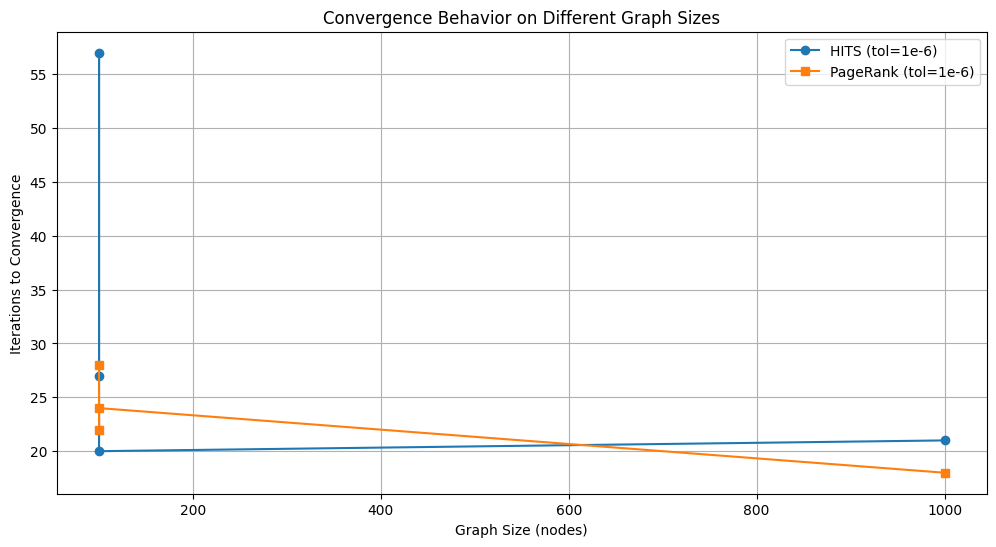

In [19]:
def plot_convergence_behavior(results):
    plt.figure(figsize=(12, 6))

    # Prepare data
    sizes = [res['Size'] for res in results]
    hits_iters = [res['HITS_1e-6'] for res in results]
    pr_iters = [res['PR_1e-6'] for res in results]

    # Plot
    plt.plot(sizes, hits_iters, 'o-', label='HITS (tol=1e-6)')
    plt.plot(sizes, pr_iters, 's-', label='PageRank (tol=1e-6)')

    plt.xlabel('Graph Size (nodes)')
    plt.ylabel('Iterations to Convergence')
    plt.title('Convergence Behavior on Different Graph Sizes')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_convergence_behavior(convergence_rates)

# Generative Search Engine

In [20]:
class GenerativeSearchEngine:
    def __init__(self, llm_model, graph_algorithm='pagerank'):
        self.llm = llm_model
        self.graph_algorithm = graph_algorithm
        self.index = {}

    def index_document(self, doc_id, content, links):
        self.index[doc_id] = {
            'content': content,
            'links': links,
            'embedding': self.llm.embed(content)
        }

    def search(self, query, top_k=10):
        # Step 1: Traditional link analysis
        adj_matrix = self._build_adjacency_matrix()
        if self.graph_algorithm == 'hits':
            _, auth_scores = hits_algorithm(adj_matrix)
        else:
            auth_scores = pagerank(adj_matrix)

        # Step 2: Semantic matching
        query_embedding = self.llm.embed(query)
        semantic_scores = {
            doc_id: cosine_similarity(query_embedding, doc['embedding'])
            for doc_id, doc in self.index.items()
        }

        # Step 3: Combined ranking
        combined_scores = {
            doc_id: 0.7*auth_scores[doc_id] + 0.3*semantic_scores[doc_id]
            for doc_id in self.index
        }

        # Step 4: Generate enhanced results
        results = []
        for doc_id in sorted(combined_scores, key=combined_scores.get, reverse=True)[:top_k]:
            doc = self.index[doc_id]
            summary = self.llm.generate(
                f"Summarize this document for query '{query}': {doc['content']}"
            )
            results.append({
                'doc_id': doc_id,
                'score': combined_scores[doc_id],
                'summary': summary
            })

        return results